In [8]:
%pip install numpy keras tensorflow scikit-learn pillow matplotlib

     ---------------------------------------- 1.0/1.0 MB 686.0 kB/s eta 0:00:00
  Using cached tensorflow-2.15.0-cp310-cp310-win_amd64.whl (2.1 kB)
  Using cached h5py-3.10.0-cp310-cp310-win_amd64.whl (2.7 MB)
  Using cached namex-0.0.7-py3-none-any.whl (5.8 kB)
  Using cached rich-13.7.0-py3-none-any.whl (240 kB)
  Using cached dm_tree-0.1.8-cp310-cp310-win_amd64.whl (101 kB)
  Using cached absl_py-2.0.0-py3-none-any.whl (130 kB)
     ------------------------------------ 300.9/300.9 MB 701.1 kB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ---------------------------------------- 3.7/3.7 MB 736.0 kB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 730.3 kB/s eta 0:00:00
  Using cached wrapt-1.14.1-cp310-cp310-win_amd64.whl (35 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     -------------------------------------- 24.4/24.4 MB 722.1 kB/s eta 0:00:00
     ------------------------------------ 413.4/413.4 kB 759.3 

In [9]:
import numpy as np
from keras.datasets import cifar100

# Загрузка CIFAR-100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Индексы классов для велосипедов и мотоциклов
bicycle_class_index = 8
motorcycle_class_index = 48

# Функция для фильтрации и создания датасета с тремя классами
def filter_dataset(x, y, class1, class2):
    class1_indices = np.where(y.flatten() == class1)[0]
    class2_indices = np.where(y.flatten() == class2)[0]
    background_indices = np.where((y.flatten() != class1) & (y.flatten() != class2))[0]
    
    # Берем подвыборку для фона, чтобы сбалансировать классы
    background_sample_indices = np.random.choice(background_indices, size=600, replace=False)
    
    # Объединяем индексы
    selected_indices = np.concatenate([class1_indices, class2_indices, background_sample_indices])
    
    # Фильтруем данные
    x_selected = x[selected_indices]
    y_selected = y[selected_indices]
    
    # Переназначаем метки классов: 0 - велосипеды, 1 - мотоциклы, 2 - фон
    y_selected = np.where(y_selected.flatten() == class1, 0, 
                          np.where(y_selected.flatten() == class2, 1, 2))
    
    return x_selected, y_selected

x_train_filtered, y_train_filtered = filter_dataset(x_train, y_train, bicycle_class_index, motorcycle_class_index)
x_test_filtered, y_test_filtered = filter_dataset(x_test, y_test, bicycle_class_index, motorcycle_class_index)

169001437/169001437 [==============================] - 363s 2us/step


In [10]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# Загрузка ResNet50 без верхнего слоя
base_model = ResNet50(weights='imagenet', include_top=False)

# Добавление новых слоев
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Собираем новую модель
model = Model(inputs=base_model.input, outputs=predictions)

# Замораживаем веса претренированной модели
for layer in base_model.layers:
    layer.trainable = False

# Компилируем модель
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 44s 0us/step


In [13]:
from keras.preprocessing.image import ImageDataGenerator

# Аугментация данных
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Обучение модели
model.fit(datagen.flow(x_train_filtered, y_train_filtered, batch_size=32),
          steps_per_epoch=len(x_train_filtered) / 32, epochs=50,
          validation_data=(x_test_filtered, y_test_filtered))


Epoch 1/50
50/50 [==============================] - 3s 57ms/step - loss: 0.4326 - accuracy: 0.8275 - val_loss: 0.6569 - val_accuracy: 0.7475
Epoch 2/50
50/50 [==============================] - 3s 55ms/step - loss: 0.4310 - accuracy: 0.8288 - val_loss: 0.5587 - val_accuracy: 0.7700
Epoch 3/50
50/50 [==============================] - 3s 55ms/step - loss: 0.4215 - accuracy: 0.8250 - val_loss: 0.5685 - val_accuracy: 0.7738
Epoch 4/50
50/50 [==============================] - 3s 56ms/step - loss: 0.4013 - accuracy: 0.8281 - val_loss: 0.6195 - val_accuracy: 0.7563
Epoch 5/50
50/50 [==============================] - 3s 55ms/step - loss: 0.3960 - accuracy: 0.8413 - val_loss: 0.5602 - val_accuracy: 0.7825
Epoch 6/50
50/50 [==============================] - 3s 55ms/step - loss: 0.4150 - accuracy: 0.8344 - val_loss: 0.5923 - val_accuracy: 0.7563
Epoch 7/50
50/50 [==============================] - 3s 55ms/step - loss: 0.3967 - accuracy: 0.8419 - val_loss: 0.5761 - val_accuracy: 0.7625
Epoch 8/50
50

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Оценка модели
y_pred = model.predict(x_test_filtered)
y_pred_classes = np.argmax(y_pred, axis=1)

# Выводим classification report и confusion matrix
print(classification_report(y_test_filtered, y_pred_classes))

25/25 [==============================] - 1s 37ms/step
              precision    recall  f1-score   support

           0       0.46      0.74      0.57       100
           1       0.38      0.85      0.52       100
           2       0.98      0.67      0.80       600

    accuracy                           0.70       800
   macro avg       0.60      0.75      0.63       800
weighted avg       0.84      0.70      0.73       800


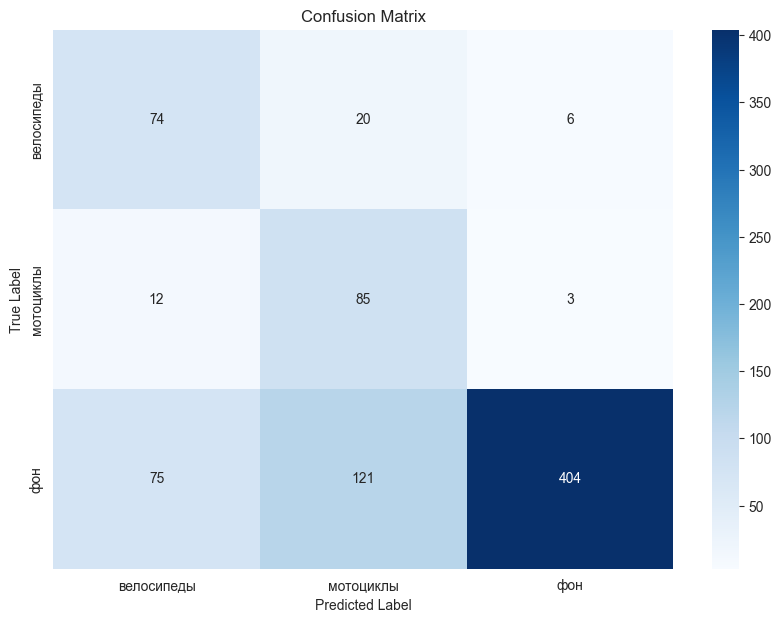

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
classes = ['велосипеды', 'мотоциклы', 'фон']
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test_filtered, y_pred_classes), annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [21]:
%pip install onnx tf2onnx onnxruntime tensorrt pycuda tvm


  Using cached onnx-1.15.0-cp310-cp310-win_amd64.whl (14.3 MB)
  Using cached tf2onnx-1.15.1-py3-none-any.whl (454 kB)
     ---------------------------------------- 7.4/7.4 MB 820.8 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.7/1.7 MB 843.1 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
     -------------------------------------- 70.6/70.6 kB 957.4 kB/s eta

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [82 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\tensorrt
  copying tensorrt\__init__.py -> build\lib\tensorrt
  running egg_info
  writing tensorrt.egg-info\PKG-INFO
  writing dependency_links to tensorrt.egg-info\dependency_links.txt
  writing requirements to tensorrt.egg-info\requires.txt
  writing top-level names to tensorrt.egg-info\top_level.txt
  reading manifest file 'tensorrt.egg-info\SOURCES.txt'
  adding license file 'LICENSE.txt'
  writing manifest file 'tensorrt.egg-info\SOURCES.txt'
  C:\Users\Витя Кенг\PycharmProjects\HW_IIAD2023\venv\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
    warnings.warn(
  installing to build\bdist.win-amd64\wheel
  running i

In [28]:
import onnx
import tf2onnx

onnx_model, _ = tf2onnx.convert.from_keras(model)
onnx.save_model(onnx_model, 'model.onnx')

Could not search for non-variable resources. Concrete function internal representation may have changed.
pass1 convert failed for name: "model/conv1_conv/Conv2D"
op: "Conv2D"
input: "model/conv1_pad/Pad"
input: "model/conv1_conv/Conv2D/ReadVariableOp"
attr {
  key: "use_cudnn_on_gpu"
  value {
    b: true
  }
}
attr {
  key: "strides"
  value {
    list {
      i: 1
      i: 2
      i: 2
      i: 1
    }
  }
}
attr {
  key: "padding"
  value {
    s: "VALID"
  }
}
attr {
  key: "explicit_paddings"
  value {
    list {
    }
  }
}
attr {
  key: "dilations"
  value {
    list {
      i: 1
      i: 1
      i: 1
      i: 1
    }
  }
}
attr {
  key: "data_format"
  value {
    s: "NHWC"
  }
}
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
, ex=Could not infer attribute `explicit_paddings` type from empty iterator


ValueError: Could not infer attribute `explicit_paddings` type from empty iterator

In [ ]:
import onnxruntime as ort
import numpy as np

# Загрузка модели ONNX
session = ort.InferenceSession('model.onnx')

# Подготовка входных данных
input_name = session.get_inputs()[0].name
input_shape = session.get_inputs()[0].shape
input_data = np.random.randn(*input_shape).astype(np.float32)

# Выполнение инференса
outputs = session.run(None, {input_name: input_data})

# Вывод результатов
print(outputs)
